<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/BIGGAN_birds_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
!pip install tensorflow-gan tensorflow-addons imageio -q
!rm -rf sample_data BigGANUtils checkpoints samples
!mkdir checkpoints samples
!git clone https://github.com/xarvel/BigGANUtils.git

Cloning into 'BigGANUtils'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 119 (delta 76), reused 68 (delta 29), pack-reused 0
Receiving objects: 100% (119/119), 34.93 MiB | 10.38 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [78]:
import tensorflow.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, ReLU,  BatchNormalization, Reshape, Embedding
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import time
from IPython import display
import numpy as np
from tqdm import tqdm 
import imageio
import glob
import IPython
import math
from BigGANUtils.SelfAttention import SelfAttention
from BigGANUtils.GBlock import GBlock
from BigGANUtils.DBlock import DBlock
from BigGANUtils.SpectralNormalization import SpectralNormalization
from BigGANUtils.ConditionalBatchNormalization import ConditionalBatchNormalization
from BigGANUtils.SNDense import SNDense 
from BigGANUtils.SNConv2D import SNConv2D
from BigGANUtils.SNEmbedding import SNEmbedding

print(tf.__version__)

2.9.2


In [79]:
#@title TPU CONFIG

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [80]:
#@title CONSTS

IMAGE_SIZE = 32
IMAGE_CHANNELS = 3
DATASET_SIZE = 13262
BUFFER_SIZE = DATASET_SIZE
PER_REPILICA_BATCH_SIZE = 8
GLOBAL_BATCH_SIZE = PER_REPILICA_BATCH_SIZE * strategy.num_replicas_in_sync
EPOCHS = 25
LATENT_DIM = 120
CHECKPOINT_DIR = 'checkpoints'
SAMPLES_DIR = 'samples'
CHECKPOINT_INTERVAL = 10
SEED = 1
SAMPLE_INTERVAL = 1
NUM_CLASSES = 100
TFRECORD_PATH = 'gs://brids-xarvel/*.tfrec'

GAN_FILTERS = 64
GENERATOR_LR = 0.0001
DISCRIMINATOR_LR = 0.0004
ADAM_BETA_1 = 0.0
ADAM_BETA_2 = 0.99
ADAM_EPSILON = 1e-07

In [81]:
tf.random.set_seed(SEED)

weight_initializer = 'orthogonal' 

# weight_initializer = tf.keras.initializers.RandomNormal(
#     mean=0.0, stddev=0.02, seed=SEED
# )
     

In [82]:
#@title Dataset

def preprocess_image(img):
    return tf.cast(img, tf.float32) / 127.5 - 1.

def get_tfrecord_dataset(
    batch_size: int,
    tfrecord_path: str,
    is_training: bool,
    *,
    image_size: int,
):
    def parse_example(proto):
        features = {
          "image": tf.io.FixedLenFeature([], tf.string), 
          'height': tf.io.FixedLenFeature([], tf.int64),
          'width': tf.io.FixedLenFeature([], tf.int64),
          'channels': tf.io.FixedLenFeature([], tf.int64),
          'label_text': tf.io.FixedLenFeature([], tf.string), 
          'label_onehot':  tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
          'label_number': tf.io.FixedLenFeature([], tf.int64),
        }

        parsed = tf.io.parse_single_example(
            serialized=proto,
            features=features
        )

        image, label = parsed["image"], parsed["label_number"]
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (image_size, image_size))
    
        return image, label

    def augment(image, label):
      image = tf.image.random_flip_left_right(
          image, seed=SEED
      )

      return image, label  
    
    tfrecord_files = tf.io.gfile.glob(tfrecord_path)

    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_example)
    
    if is_training:
      dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True, seed=SEED)
      dataset = dataset.repeat()
      dataset = dataset.map(augment)

    dataset = dataset.map(lambda image, label: (preprocess_image(image), label))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
   
    return dataset

train_dataset = get_tfrecord_dataset(
    batch_size=GLOBAL_BATCH_SIZE,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=False
) 

In [83]:
class Generator(Model):
  def __init__(self, channels, num_classes, embedding_size):
    super(Generator, self).__init__()
    self.channels = channels
    self.linear = SNDense(4 * 4 * 4 * channels, use_bias=False, kernel_initializer=weight_initializer)
    self.reshape = Reshape([4, 4, 4 * channels])

    self.res_block_1 = GBlock(4 * channels, kernel_initializer=weight_initializer)
    self.res_block_2 = GBlock(4 * channels, kernel_initializer=weight_initializer)
    self.attention = SelfAttention(kernel_initializer=weight_initializer)
    self.res_block_3 = GBlock(4 * channels, kernel_initializer=weight_initializer)
    self.embedding = Embedding(num_classes, embedding_size, embeddings_initializer=weight_initializer)

    self.bn = BatchNormalization()
    self.activation = ReLU()
    self.conv = SNConv2D(filters=IMAGE_CHANNELS, kernel_size=3, padding='same', kernel_initializer=weight_initializer)
    self.concat = Concatenate();

  @tf.function
  def call(self, z, label, training=False):    
    z_split = tf.split(z, num_or_size_splits=4, axis=-1)
    embed = self.embedding(label)
    conds = [self.concat([z_i, embed]) for z_i in z_split[1:]]
    x = self.linear(z_split[0], training=training)
    x = self.reshape(x)
    x = self.res_block_1(x, conds[0], training=training)
    x = self.res_block_2(x, conds[1], training=training)
    x = self.attention(x, training=training)
    x = self.res_block_3(x, conds[2], training=training)
    x = self.bn(x, training=training)
    x = self.activation(x)
    x = self.conv(x, training=training)
    return tf.nn.tanh(x)

In [84]:
class Discriminator(Model):
  def __init__(self, channels, num_classes):
    super(Discriminator, self).__init__()
    self.res_block_1 = DBlock(4 * channels, downsample=True, preactivation=False, kernel_initializer=weight_initializer)
    self.res_block_2 = DBlock(4 * channels, downsample=True, preactivation=True, kernel_initializer=weight_initializer)
    self.res_block_3 = DBlock(4 * channels, downsample=False, preactivation=True, kernel_initializer=weight_initializer)
    self.attention = SelfAttention(kernel_initializer=weight_initializer)
    self.res_block_4 = DBlock(4 * channels, downsample=False, preactivation=True, kernel_initializer=weight_initializer)
    self.activation = ReLU()
    self.embedding = SNEmbedding(num_classes, 4 * channels, embeddings_initializer=weight_initializer)
    self.linear = SNDense(1, kernel_initializer=weight_initializer)
    
  @tf.function
  def call(self, x, label, training=False):
    x = self.res_block_1(x, training=training)
    x = self.res_block_2(x, training=training)
    x = self.res_block_3(x, training=training)
    x = self.attention(x, training=training)
    x = self.res_block_4(x, training=training)
    x = self.activation(x)
    x = tf.reduce_sum(x, axis=[1, 2])
    out = self.linear(x, training=training)
    embed = self.embedding(label)
    out += tf.reduce_sum(x * embed, axis=-1, keepdims=True)
    return out

In [85]:
with strategy.scope():
  generator = Generator(GAN_FILTERS, num_classes=NUM_CLASSES, embedding_size=LATENT_DIM)
  discriminator = Discriminator(GAN_FILTERS, num_classes=NUM_CLASSES)

In [86]:
train_dataset = strategy.distribute_datasets_from_function(
    lambda _: get_tfrecord_dataset(
    batch_size=PER_REPILICA_BATCH_SIZE,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=True
))

In [87]:
def discriminator_loss(logits_real: tf.Tensor, logits_fake: tf.Tensor) -> tf.Tensor :
  real_loss = tf.reduce_mean(tf.nn.relu(1.0 - logits_real))
  fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + logits_fake))
  total_loss = real_loss + fake_loss
  return total_loss / GLOBAL_BATCH_SIZE

def generator_loss(logits_fake: tf.Tensor) -> tf.Tensor:
  loss = -tf.reduce_mean(logits_fake)
  
  return loss / GLOBAL_BATCH_SIZE

In [88]:
with strategy.scope():
  generator_optimizer = Adam(
      learning_rate=GENERATOR_LR, 
      beta_1=ADAM_BETA_1, 
      beta_2=ADAM_BETA_2,
      epsilon=ADAM_EPSILON
  )
  discriminator_optimizer = Adam(
      learning_rate=DISCRIMINATOR_LR, 
      beta_1=ADAM_BETA_1, 
      beta_2=ADAM_BETA_2, 
      epsilon=ADAM_EPSILON
  )

In [89]:
import random

fixed_noise = tf.random.truncated_normal((NUM_CLASSES, LATENT_DIM), stddev=1)

def sample_images(epoch=0, save=False, show=True):
  square_size = int(math.sqrt(NUM_CLASSES))
  rows = square_size
  cols = square_size
  noise = fixed_noise

  labels = np.arange(0, NUM_CLASSES)
  gen_imgs = generator(noise, labels)
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  fig.subplots_adjust(
      wspace = 0.0,
      hspace = 0.0
  )
  px = 1/plt.rcParams['figure.dpi']

  fig.set_figheight(IMAGE_SIZE * rows * px)
  fig.set_figwidth(IMAGE_SIZE * cols * px)

  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(gen_imgs[j * square_size + i])
  
      axs[i,j].axis('off')

  # Create folder if not exits
  if not os.path.isdir(SAMPLES_DIR):
    os.makedirs(SAMPLES_DIR, exist_ok=True)

  if save:
    plt.savefig(SAMPLES_DIR + '/image_at_epoch_{:04d}.png'.format(epoch))
    
  if show:
    plt.show()
  else:
    plt.close(fig)

def sample_analytics(meta, save=False, show=True):
  history = meta['history']

  with plt.xkcd():
    fig, axs = plt.subplots(figsize=(10,10))
    plt.plot(history['gen_loss'], label='Generator loss')
    plt.plot(history['disc_loss'], label='Discriminator loss')
    plt.title('Learing process')
    
    plt.figtext(.7, .17, '\n'.join([
        'Epoch=%s' % meta['epoch'],
        "GEN_LR=%s" % GENERATOR_LR,
        'DISC_LR=%s' % DISCRIMINATOR_LR,
        'FILTERS=%s' % GAN_FILTERS,
        'PER_REPILICA_BATCH_SIZE=%s' % PER_REPILICA_BATCH_SIZE
    ]))

    fig.legend();

    if save:
      fig.savefig(SAMPLES_DIR + '/analytics_at_epoch_{:04d}.png'.format(meta['epoch'])) 
  
    if show:   
      plt.show()
    else:
      plt.close(fig)

In [90]:
#@title checkpoint
import json

checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")
latest_checkpoint = tf.train.latest_checkpoint(CHECKPOINT_DIR)

defaultMeta = {
    "history": {
        "disc_loss": [],
        "gen_loss": []
    },
    "epoch": 1
}
meta = defaultMeta

META_FILE = CHECKPOINT_DIR + '/meta.json'

def restore_checkpoint():
  try:
    with open(META_FILE) as f:
      meta = json.load(f)
  except:
    meta = defaultMeta
    pass
  
  status = checkpoint.restore(latest_checkpoint, options=local_device_option)
  return meta

def save_checkpoint():
  print('Saving checkpoint');

  # Create folder if not exits
  if not os.path.isdir(SAMPLES_DIR):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

  with open(META_FILE, 'w') as f:
    json.dump(meta, f)
  
  checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
  checkpoint.save(file_prefix = checkpoint_prefix, options=local_device_option)

meta = restore_checkpoint();

(1, 32, 32, 3)


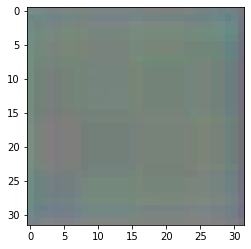

In [91]:
with strategy.scope():
  label = tf.constant([1])
  noise = tf.random.truncated_normal([1, LATENT_DIM], stddev=0.5)
  generated_image = generator(noise, label, training=False)
  print(generated_image.shape)
  plt.imshow(generated_image[0] * 0.5 + 0.5)  

In [92]:
with strategy.scope():
  decision = discriminator(generated_image, label)
  print(decision)

tf.Tensor([[1.7320564]], shape=(1, 1), dtype=float32)


In [93]:
#@title train_step

with strategy.scope():
  d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
  g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

@tf.function
def train_step(iterator):
  """The step function for one training step."""

  def step_fn(inputs):
    """The computation to run on each TPU device."""
    images, labels = inputs
    noise = tf.random.normal([PER_REPILICA_BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, labels, training=True)
      gen_predictions = discriminator(generated_images, labels, training=True)
      real_predictions = discriminator(images, labels, training=True)
      disc_loss = discriminator_loss(real_predictions, gen_predictions)
      gen_loss = generator_loss(gen_predictions)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_weights)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))
    discriminator_optimizer.apply_gradients(
      zip(gradients_of_discriminator, discriminator.trainable_weights)
    )
    
    d_loss_metric.update_state(disc_loss)
    g_loss_metric.update_state(gen_loss)
    
    return disc_loss, gen_loss

  disc_loss, gen_loss = strategy.run(step_fn, args=(next(iterator),))

  disc_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, disc_loss, axis=None)
  gen_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, gen_loss, axis=None)
  
  return disc_loss, gen_loss

In [ ]:
steps_per_epoch = DATASET_SIZE // PER_REPILICA_BATCH_SIZE
train_iterator = iter(train_dataset)

for epoch in range(meta['epoch'], EPOCHS + 1):
  meta['epoch'] = epoch
  start = time.time()
  print('Epoch: {}/{}'.format(epoch, EPOCHS))

  pbar = tqdm(range(steps_per_epoch))
  for step in pbar:
    disc_loss, gen_loss = train_step(train_iterator)
    meta['history']['disc_loss'].append(float(disc_loss));
    meta['history']['gen_loss'].append(float(gen_loss));
    pbar.set_postfix({'disc_loss': round(float(disc_loss), 4), 'gen_loss': round(float(gen_loss), 4)})
    pbar.set_description("Current step %s" % generator_optimizer.iterations.numpy())

  if epoch % SAMPLE_INTERVAL == 0:
    sample_images(epoch, save=True, show=False)
    
  if epoch % CHECKPOINT_INTERVAL == 0:
    save_checkpoint()
    sample_analytics(meta, save=True, show=False)   

  print('Time for epoch {} is {} sec'.format(epoch, time.time()-start))

Epoch: 1/25


Current step 1657: 100%|██████████| 1657/1657 [04:43<00:00,  5.85it/s, disc_loss=0.0051, gen_loss=0.0255]


Time for epoch 1 is 287.54246163368225 sec
Epoch: 2/25


Current step 3314: 100%|██████████| 1657/1657 [01:04<00:00, 25.55it/s, disc_loss=0.0022, gen_loss=0.0474]


Time for epoch 2 is 66.67989253997803 sec
Epoch: 3/25


Current step 4971: 100%|██████████| 1657/1657 [01:04<00:00, 25.50it/s, disc_loss=0.0041, gen_loss=0.0385]


Time for epoch 3 is 69.33865547180176 sec
Epoch: 4/25


Current step 6628: 100%|██████████| 1657/1657 [01:05<00:00, 25.37it/s, disc_loss=0.0087, gen_loss=0.0563]


Time for epoch 4 is 67.0526852607727 sec
Epoch: 5/25


Current step 8285: 100%|██████████| 1657/1657 [01:04<00:00, 25.55it/s, disc_loss=0.0026, gen_loss=0.0405]


Time for epoch 5 is 66.65370488166809 sec
Epoch: 6/25


Current step 9942: 100%|██████████| 1657/1657 [01:05<00:00, 25.46it/s, disc_loss=0.0045, gen_loss=0.0441]


Time for epoch 6 is 66.86038422584534 sec
Epoch: 7/25


Current step 11599: 100%|██████████| 1657/1657 [01:05<00:00, 25.49it/s, disc_loss=0.0084, gen_loss=0.0545]


Time for epoch 7 is 68.38289213180542 sec
Epoch: 8/25


Current step 13256: 100%|██████████| 1657/1657 [01:04<00:00, 25.57it/s, disc_loss=0.0067, gen_loss=0.0169]


Time for epoch 8 is 66.59944462776184 sec
Epoch: 9/25


Current step 14913: 100%|██████████| 1657/1657 [01:05<00:00, 25.45it/s, disc_loss=0.0016, gen_loss=0.0316]


Time for epoch 9 is 66.84757113456726 sec
Epoch: 10/25


Current step 16570: 100%|██████████| 1657/1657 [01:04<00:00, 25.52it/s, disc_loss=0.005, gen_loss=0.0282]


Saving checkpoint
Time for epoch 10 is 69.21889090538025 sec
Epoch: 11/25


Current step 18227: 100%|██████████| 1657/1657 [01:05<00:00, 25.48it/s, disc_loss=0.0023, gen_loss=0.04]


Time for epoch 11 is 68.86223006248474 sec
Epoch: 12/25


Current step 19843:  97%|█████████▋| 1614/1657 [01:03<00:01, 25.99it/s, disc_loss=0.0061, gen_loss=0.0556]

In [ ]:
sample_analytics(meta, save=False, show=True)    

In [ ]:
sample_images(meta['epoch'], save=False, show=True)

In [ ]:
samples = SAMPLES_DIR + '/samples.gif'

with imageio.get_writer(samples, mode='I') as writer:
  filenames = glob.glob(SAMPLES_DIR + '/image_at_epoch_*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
IPython.display.Image(filename=samples, embed=True)